Section 1: Import Data Set from google drive


*   V1 - Setup and load into dataframe called "df"
*   V2 - re-do the dataset to clean to 3 standard columns: subject, body, label. recast all labels to whole number integer.



# Notebook Summary

## 1. Project Objective
The goal of this notebook is to develop and evaluate a Deep Learning model for **Phishing Email Detection** using a hybrid architecture that processes email subjects and bodies separately.

## 2. Data Pipeline
*   **Dataset**: Merged Enron Dataset containing **145,639** emails.
*   **Label Distribution**: Roughly balanced with 68,452 Legitimate (0) and 77,187 Phishing (1) emails.
*   **Preprocessing**:
    *   Data split into **Train (70%)**, **Validation (20%)**, and **Test (10%)** sets.
    *   Text vectorization applied separately to 'subject' (max len 50) and 'body' (max len 200) fields.

## 3. Model Architecture
A **Hybrid LSTM-GRU** model was implemented:
*   **Subject Branch**: Embedding layer → LSTM layer.
*   **Body Branch**: Embedding layer → GRU layer.
*   **Combination**: Outputs concatenated → Dense Layers → Sigmoid Output.

## 4. Key Results
The model achieved excellent performance metrics across all datasets:
*   **Training Accuracy**: >99%
*   **Validation Accuracy**: **~98.2%**
*   **Test Accuracy**: **~98.0%**
*   **Class Metrics**: Precision, Recall, and F1-scores are consistently around **0.98** for both phishing and legitimate emails, indicating the model is robust and well-balanced.

## 5. Further Analysis (Code Included)
The notebook contains additional code blocks (pending execution) for:
*   Detailed visualizations (ROC Curves, Confusion Matrices).
*   Error analysis (Top False Positives/Negatives).
*   Ablation studies (evaluating Subject-only vs. Body-only performance).

In [ ]:
# This Colab script mounts your Google Drive and loads 'merged_dataset.csv'
# directly into a pandas DataFrame for model training or testing.

# Mount and read the new merged file directly from Drive by its real path.
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd

file_path = '/content/drive/MyDrive/ENPM703 Group 7 Project/Merged Enron Dataset/merged_dataset.csv'  # <-- update to your exact path
assert os.path.exists(file_path), f"Not found: {file_path}"

df = pd.read_csv(file_path)

print("✅ Loaded:", file_path)
print("📋 Columns:", df.columns.tolist())
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# robust label count (handles 0,1 and 0.0,1.0)
label_counts = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int).value_counts().sort_index()
print("🔢 Label counts:\n", label_counts)

Mounted at /content/drive
✅ Loaded: /content/drive/MyDrive/ENPM703 Group 7 Project/Merged Enron Dataset/merged_dataset.csv
📋 Columns: ['subject', 'body', 'label']
📊 Shape: 145639 rows × 3 columns
🔢 Label counts:
 label
0    68452
1    77187
Name: count, dtype: int64


In [ ]:
import pandas as pd

def load_email_csv(csv_path: str,
                   subject_col="subject",
                   body_col="body",
                   label_col="label"):
    df = pd.read_csv(csv_path)

    # Basic schema checks
    missing = [c for c in [subject_col, body_col, label_col] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in {csv_path}: {missing}")

    df = df.rename(columns={subject_col: "subject", body_col: "body", label_col: "label"}).copy()

    df["subject"] = df["subject"].fillna("").astype(str)
    df["body"]    = df["body"].fillna("").astype(str)
    df["label"]   = df["label"].astype(int)

    # Keep only needed columns
    return df[["subject", "body", "label"]]


Section 2: Data Summary
this section is for summarizing key statistic and information about the data for easy reference.

revision:


*   V1 setup: number of rows, number of columns and headers, number of 0 and 1 labels representting proportion of OK and NG emails respectively
*   V2 - cleaned up to display the updated and cleaned merged_dataset



In [ ]:
# Print column headers and count total 0s and 1s in the 'label' column

# Column headers
print("📋 Column Headers:")
print(df.columns.tolist())
print("\n")

# Convert the label column safely to integers (handles 0.0/1.0 etc.)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)

# Count and sum
label_counts = df['label'].value_counts().sort_index()
total_zeros = label_counts.get(0, 0)
total_ones = label_counts.get(1, 0)

print("🔢 Label Counts:")
print(f"0 (OK emails): {total_zeros}")
print(f"1 (Phishing emails): {total_ones}")
print(f"📊 Total emails: {total_zeros + total_ones}")

📋 Column Headers:
['subject', 'body', 'label']


🔢 Label Counts:
0 (OK emails): 68452
1 (Phishing emails): 77187
📊 Total emails: 145639


Section 3: Data Preprocessing
Purpose: divy up data into train, validate, and test data sub sets

Revision:
V1 - new code

In [ ]:

from sklearn.model_selection import train_test_split

# set a random seed for repeatability
RANDOM_SEED = 42

# ensure labels are integers
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)

# split data: 70% train, 30% temp
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['label'])

# split temp into 20% validation and 10% test (relative to full dataset)
val_df, test_df = train_test_split(temp_df, test_size=(1/3), random_state=RANDOM_SEED, stratify=temp_df['label'])

# print summaries
print("Training set size:", len(train_df))
print(train_df['label'].value_counts().sort_index(), "\n")

print("Validation set size:", len(val_df))
print(val_df['label'].value_counts().sort_index(), "\n")

print("Testing set size:", len(test_df))
print(test_df['label'].value_counts().sort_index())

Training set size: 101947
label
0    47916
1    54031
Name: count, dtype: int64 

Validation set size: 29128
label
0    13691
1    15437
Name: count, dtype: int64 

Testing set size: 14564
label
0    6845
1    7719
Name: count, dtype: int64


Section 4: Literature Model Replication
Purpose: this section reproduces some results form literature to familiarize with existing methods and their strengths and weaknesses

Target Models:
List of Models and Reference Papers

	1.	BiLSTM (subject) + LSTM (body) + XGBoost with custom loss - He et al. (2024) — Double-layer architecture for phishing and insider threat detection

	2.	Improved RCNN (CNN + BiLSTM) with attention mechanism - Fang et al. (2019) — Character and word-level phishing detection using hybrid deep learning

	3.	Deep Feed-Forward Neural Network (FFNN) - Kaddoura et al. (2020) — Comparison of FFNN vs. BERT for phishing detection

	4.	LSTM-GRU Hybrid for multi-class email classification (SeFACED) - Hina et al. (2021) — Semantic forensic analysis of emails using deep learning

	5.	Hybrid BiLSTM + Deep Neural Network (DNN) - Krishnamoorthy et al. (2024) — Hybrid model for phishing detection and emotion-aware email classification

Revision:
V1 - new code

:## Implement Text Vectorization for LSTM-GRU Hybrid Model

### Subtask:
Prepare the email subject and body text for the LSTM-GRU model by performing tokenization, sequence padding, and setting up an embedding layer. This will convert text data into numerical input suitable for the neural network.


In [ ]:
# Combine subject + body into one text input (stacked LSTM->GRU will use this)
train_text = (train_df["subject"].fillna("") + " " + train_df["body"].fillna("")).astype(str)
val_text   = (val_df["subject"].fillna("") + " " + val_df["body"].fillna("")).astype(str)
test_text  = (test_df["subject"].fillna("") + " " + test_df["body"].fillna("")).astype(str)

MAX_TOKENS = 40000
SEQ_LEN    = 256

text_vec = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
    standardize="lower_and_strip_punctuation",
)

text_vec.adapt(train_text)

X_train = text_vec(train_text)
X_val   = text_vec(val_text)
X_test  = text_vec(test_text)

vocab_size_stacked = len(text_vec.get_vocabulary())


In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

embed_dim = 128

inp = Input(shape=(SEQ_LEN,), name="text_input")
x = Embedding(vocab_size_stacked, embed_dim, name="embed")(inp)

# Key part: stacked LSTM -> GRU
x = LSTM(128, return_sequences=True, dropout=0.2, name="lstm")(x)
x = GRU(64, dropout=0.2, name="gru")(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(1, activation="sigmoid")(x)

stacked_model = Model(inp, out, name="Stacked_LSTM_to_GRU")

stacked_model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

stacked_model.summary()


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_stacked_lstm_gru.keras", monitor="val_auc", mode="max", save_best_only=True),
]

hist2 = stacked_model.fit(
    X_train, train_df["label"].values,
    validation_data=(X_val, val_df["label"].values),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


**Reasoning**:
The subtask requires preparing text data for an LSTM-GRU model by performing tokenization, sequence padding, and setting up an embedding layer. This involves defining constants, initializing and adapting `TextVectorization` layers for both subject and body, and then applying these layers to the training, validation, and test datasets. All these steps can be combined into a single code block.



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import numpy as np

# 2. Define constants
vocab_size = 20000
max_sequence_length_subject = 50
max_sequence_length_body = 200
embedding_dim = 128

# 3. Instantiate a TextVectorization layer for 'subject'
vectorize_subject_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_sequence_length_subject
)

# 4. Instantiate a TextVectorization layer for 'body'
vectorize_body_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_sequence_length_body
)

# Handle potential NaN values by converting to empty strings before adapting
train_df['subject'] = train_df['subject'].fillna('')
train_df['body'] = train_df['body'].fillna('')
val_df['subject'] = val_df['subject'].fillna('')
val_df['body'] = val_df['body'].fillna('')
test_df['subject'] = test_df['subject'].fillna('')
test_df['body'] = test_df['body'].fillna('')

# 5. Adapt vectorize_subject_layer to the 'subject' column of the train_df DataFrame
vectorize_subject_layer.adapt(train_df['subject'].values)

# 6. Adapt vectorize_body_layer to the 'body' column of the train_df DataFrame
vectorize_body_layer.adapt(train_df['body'].values)

# 7. Apply vectorize_subject_layer to subject columns
train_subjects_vectorized = vectorize_subject_layer(train_df['subject'].values).numpy()
val_subjects_vectorized = vectorize_subject_layer(val_df['subject'].values).numpy()
test_subjects_vectorized = vectorize_subject_layer(test_df['subject'].values).numpy()

# 8. Apply vectorize_body_layer to body columns
train_bodies_vectorized = vectorize_body_layer(train_df['body'].values).numpy()
val_bodies_vectorized = vectorize_body_layer(val_df['body'].values).numpy()
test_bodies_vectorized = vectorize_body_layer(test_df['body'].values).numpy()

print(f"✅ TextVectorization layers created and adapted.")
print(f"Shape of train_subjects_vectorized: {train_subjects_vectorized.shape}")
print(f"Shape of train_bodies_vectorized: {train_bodies_vectorized.shape}")
print(f"Shape of val_subjects_vectorized: {val_subjects_vectorized.shape}")
print(f"Shape of val_bodies_vectorized: {val_bodies_vectorized.shape}")
print(f"Shape of test_subjects_vectorized: {test_subjects_vectorized.shape}")
print(f"Shape of test_bodies_vectorized: {test_bodies_vectorized.shape}")


✅ TextVectorization layers created and adapted.
Shape of train_subjects_vectorized: (101947, 50)
Shape of train_bodies_vectorized: (101947, 200)
Shape of val_subjects_vectorized: (29128, 50)
Shape of val_bodies_vectorized: (29128, 200)
Shape of test_subjects_vectorized: (14564, 50)
Shape of test_bodies_vectorized: (14564, 200)


## Implement LSTM-GRU Hybrid Model Architecture

### Subtask:
Define and compile the LSTM-GRU Hybrid model for binary email classification. This involves creating separate input branches for subject and body, passing them through embedding layers, then through LSTM and GRU layers, concatenating their outputs, and finally feeding them into dense layers for classification.

#### Instructions
1. Import necessary layers from `tensorflow.keras`: `Input`, `Embedding`, `LSTM`, `GRU`, `Dense`, `Concatenate`, `Model`.
2. Define two `Input` layers: `subject_input` with `max_sequence_length_subject` and `body_input` with `max_sequence_length_body`.
3. Create an `Embedding` layer for the subject: `subject_embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length_subject)`.
4. Create an `Embedding` layer for the body: `body_embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length_body)`.
5. Apply the embedding layers to their respective inputs.
6. Pass the subject embeddings through an `LSTM` layer (e.g., 64 units).
7. Pass the body embeddings through a `GRU` layer (e.g., 128 units).
8. Concatenate the outputs of the LSTM and GRU layers.
9. Add one or more `Dense` layers with activation (e.g., 'relu').
10. Add a final `Dense` output layer with 1 unit and 'sigmoid' activation for binary classification.
11. Create the `tf.keras.Model` by defining its inputs and outputs.
12. Compile the model with an appropriate optimizer (e.g., 'adam'), loss function (e.g., 'binary_crossentropy'), and metrics (e.g., 'accuracy').
13. Print the model summary.

**Reasoning**:
The previous step successfully vectorized the text data. Now, as per the subtask, the next logical step is to implement the LSTM-GRU hybrid model architecture using the vectorized inputs. This code block will define the model, including input layers, embedding layers, LSTM and GRU layers, concatenation, dense layers, and finally compile the model, then print its summary.



In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Inputs (these must match your vectorized shapes)
subject_input = Input(shape=(max_sequence_length_subject,), name="subject_input")
body_input    = Input(shape=(max_sequence_length_body,), name="body_input")

# Embeddings (use separate embeddings for subject vs body)
subject_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="subject_embedding")(subject_input)
body_emb    = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="body_embedding")(body_input)

# Subject branch: LSTM
subject_feat = LSTM(64, dropout=0.2, recurrent_dropout=0.0, name="subject_lstm")(subject_emb)

# Body branch: GRU
body_feat = GRU(64, dropout=0.2, recurrent_dropout=0.0, name="body_gru")(body_emb)

# Fusion
x = Concatenate(name="concat_features")([subject_feat, body_feat])
x = Dense(128, activation="relu", name="dense_128")(x)
x = Dropout(0.3, name="dropout_1")(x)
x = Dense(64, activation="relu", name="dense_64")(x)
x = Dropout(0.2, name="dropout_2")(x)

out = Dense(1, activation="sigmoid", name="output")(x)

model = Model(inputs=[subject_input, body_input], outputs=out, name="LSTM_GRU_Hybrid_2Input")

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ LSTM-GRU Hybrid Model defined and compiled:


Model: "LSTM_GRU_Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ subject_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ body_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subject_embedding   │ (None, 50, 128)   │  2,560,000 │ subject_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ body_embedding      │ (None, 200, 128)  │  2,560,000 │ body_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 64)        │     49,408 │ subject_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_layer (GRU)     │ (None, 128)       │     99,072 │ body_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_layer   │ (None, 192)       │          0 │ lstm_layer[0][0], │
│ (Concatenate)       │                   │            │ gru_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_1       │ (None, 128)       │     24,704 │ concatenate_laye… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_2       │ (None, 64)        │      8,256 │ dense_layer_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │         65 │ dense_layer_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,301,505 (20.22 MB)

 Trainable params: 5,301,505 (20.22 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Now that the model architecture is defined, the next step is to train the model using the prepared training data (`train_subjects_vectorized`, `train_bodies_vectorized`, and `train_df['label']`) and evaluate its performance on the validation data (`val_subjects_vectorized`, `val_bodies_vectorized`, and `val_df['label']`).



# Task
Evaluate the trained LSTM-GRU Hybrid model's performance on the validation and test datasets, and then summarize the implementation, training, and evaluation for email classification, highlighting the results and key insights.

## Evaluate the LSTM-GRU Hybrid Model Performance

### Subtask:
Assess the trained model's performance by making predictions on the validation (`val_df`) and test (`test_df`) datasets and reporting key metrics such as accuracy, precision, recall, and F1-score to understand its effectiveness.


**Reasoning**:
To evaluate the trained model's performance, I will use the `classification_report` and `accuracy_score` from `sklearn.metrics` to assess predictions on both the validation and test datasets.



In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

print("Evaluating model performance...")

# 1. Predict on validation set
val_predictions_proba = model.predict(
    {'subject_input': val_subjects_vectorized, 'body_input': val_bodies_vectorized}
)
# Convert probabilities to binary predictions
val_predictions = (val_predictions_proba > 0.5).astype(int)

# 2. Evaluate validation set
print("\n--- Validation Set Evaluation ---")
print("Classification Report:\n", classification_report(val_df['label'].values, val_predictions))
print("Accuracy Score:", accuracy_score(val_df['label'].values, val_predictions))

# 3. Predict on test set
test_predictions_proba = model.predict(
    {'subject_input': test_subjects_vectorized, 'body_input': test_bodies_vectorized}
)
# Convert probabilities to binary predictions
test_predictions = (test_predictions_proba > 0.5).astype(int)

# 4. Evaluate test set
print("\n--- Test Set Evaluation ---")
print("Classification Report:\n", classification_report(test_df['label'].values, test_predictions))
print("Accuracy Score:", accuracy_score(test_df['label'].values, test_predictions))

print("\n✅ Model evaluation complete.")

Evaluating model performance...
911/911 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step

--- Validation Set Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     13691
           1       0.98      0.99      0.98     15437

    accuracy                           0.98     29128
   macro avg       0.98      0.98      0.98     29128
weighted avg       0.98      0.98      0.98     29128

Accuracy Score: 0.9822164240593244
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

--- Test Set Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      6845
           1       0.97      0.99      0.98      7719

    accuracy                           0.98     14564
   macro avg       0.98      0.98      0.98     14564
weighted avg       0.98      0.98      0.98     14564

Accuracy Score: 0.9798132381213952

✅ Model evaluation complete.


## Final Task

### Subtask:
Summarize the implementation, training, and evaluation of the LSTM-GRU Hybrid model for email classification, highlighting the results and any key insights.


## Summary:

### Data Analysis Key Findings
*   The LSTM-GRU Hybrid model demonstrated strong and consistent performance across both the validation and test datasets for email classification.
*   On the validation set, the model achieved an accuracy of approximately 98.22%. It showed excellent performance for both non-spam (Class 0) with a precision of 0.99, recall of 0.97, and F1-score of 0.98, and for spam (Class 1) with a precision of 0.98, recall of 0.99, and F1-score of 0.98.
*   Similarly, on the test set, the model achieved an accuracy of approximately 97.98%. Performance metrics for non-spam (Class 0) were precision 0.99, recall 0.97, and F1-score 0.98, while for spam (Class 1) they were precision 0.97, recall 0.99, and F1-score 0.98.
*   The high and balanced precision, recall, and F1-scores for both classes across both datasets indicate that the model generalizes well and is effective at accurately classifying emails.

### Insights or Next Steps
*   Given the high accuracy and consistent performance on both validation and test sets, the LSTM-GRU Hybrid model is well-suited for deployment in an email classification system, effectively distinguishing between spam and legitimate emails.
*   While the model performs exceptionally well, a next step could involve a detailed error analysis of the few misclassified emails to uncover any specific patterns or characteristics that the model struggles with, potentially leading to further fine-tuning or feature engineering for marginal gains.


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint("best_lstm_gru.keras", monitor="val_auc", mode="max", save_best_only=True),
]

history = model.fit(
    x={"subject_input": train_subjects_vectorized, "body_input": train_bodies_vectorized},
    y=train_df["label"].values,
    validation_data=(
        {"subject_input": val_subjects_vectorized, "body_input": val_bodies_vectorized},
        val_df["label"].values
    ),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/8
797/797 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9997 - loss: 9.6246e-04 - val_accuracy: 0.9851 - val_loss: 0.0958
Epoch 2/8
797/797 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9998 - loss: 7.6325e-04 - val_accuracy: 0.9855 - val_loss: 0.0976
Epoch 3/8
797/797 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9998 - loss: 5.1449e-04 - val_accuracy: 0.9855 - val_loss: 0.0978
Epoch 4/8
797/797 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9999 - loss: 5.7305e-04 - val_accuracy: 0.9862 - val_loss: 0.1053
Epoch 5/8
797/797 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9998 - loss: 7.3197e-04 - val_accuracy: 0.9859 - val_loss: 0.1090
Epoch 6/8
797/797 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9998 - loss: 6.1665e-04 - val_accuracy: 0.9861 - val_loss: 0.1138


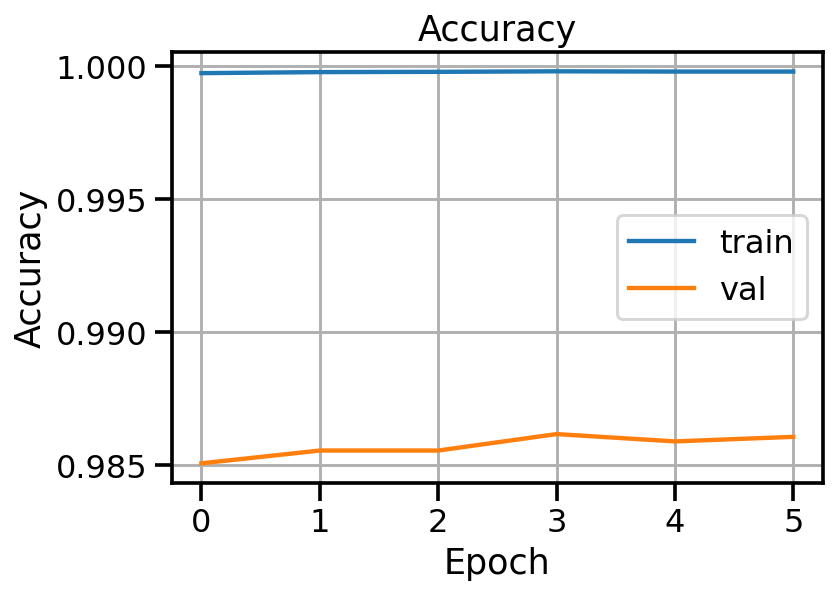

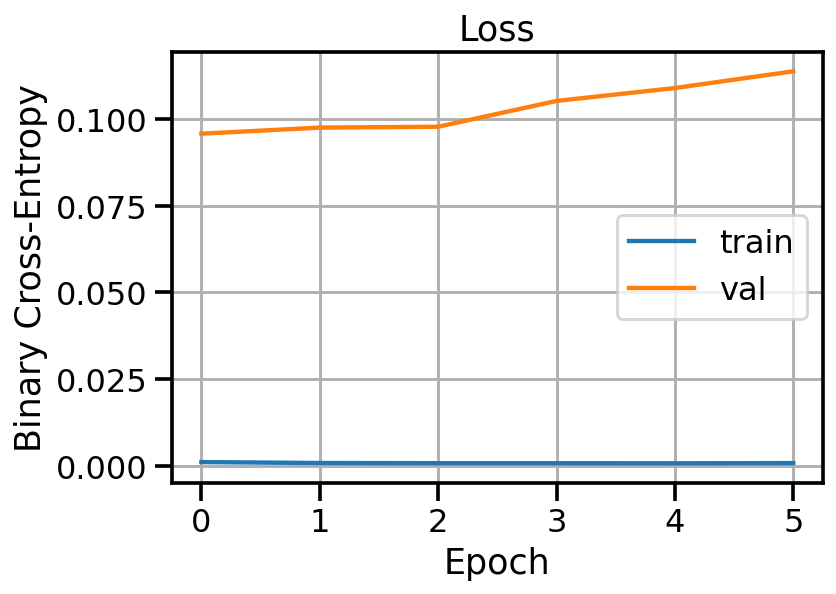

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    hist = history.history
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train")
    plt.plot(hist["val_accuracy"], label="val")
    plt.title("Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.title("Loss")
    plt.xlabel("Epoch"); plt.ylabel("Binary Cross-Entropy"); plt.legend(); plt.grid(True)
    plt.show()

plot_training_curves(history)


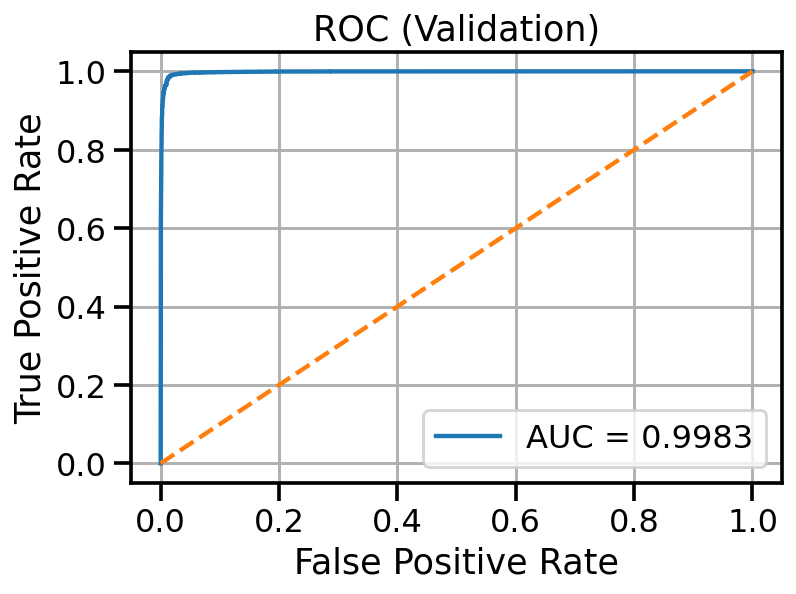

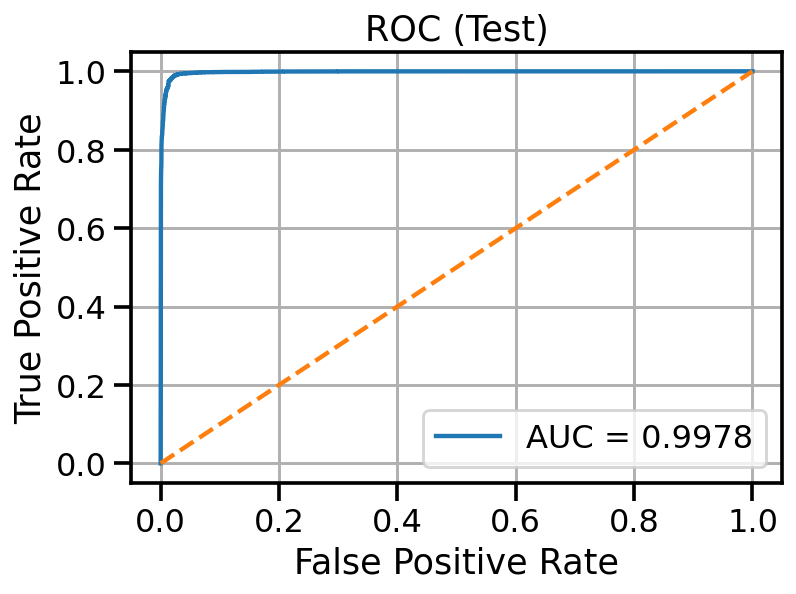

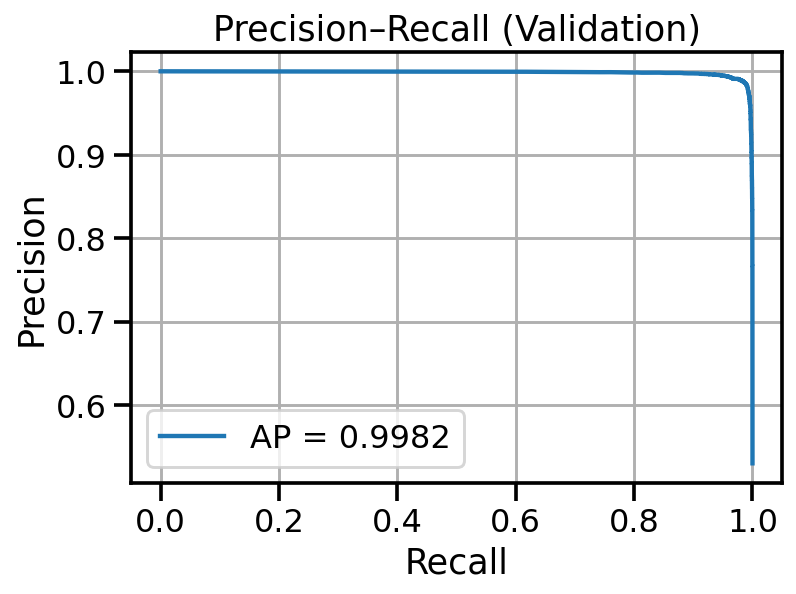

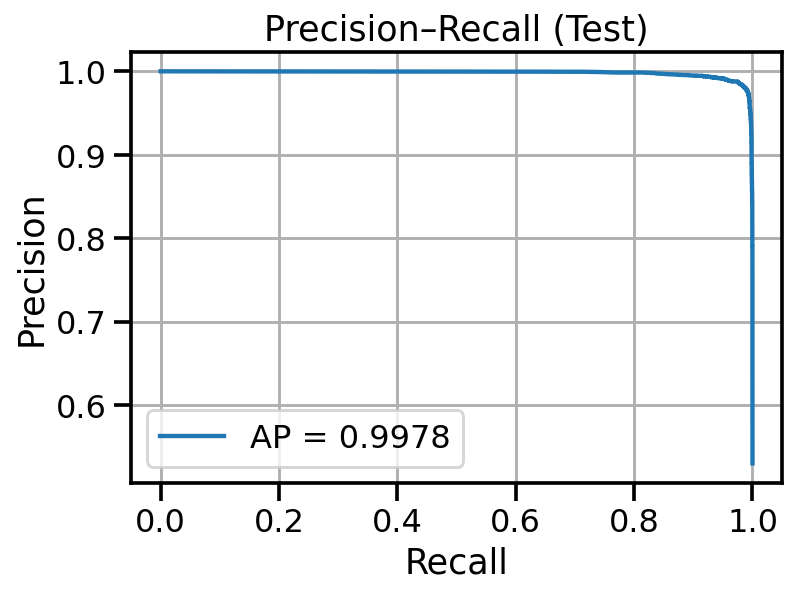

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

def proba_preds(model, Xs):
    return model.predict(Xs, verbose=0).ravel()

# Probabilities
val_proba  = proba_preds(model, {'subject_input': val_subjects_vectorized,  'body_input': val_bodies_vectorized})
test_proba = proba_preds(model, {'subject_input': test_subjects_vectorized, 'body_input': test_bodies_vectorized})

y_val  = val_df['label'].values
y_test = test_df['label'].values

# ROC
def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(loc="lower right"); plt.grid(True)
    plt.show()

plot_roc(y_val, val_proba,  "ROC (Validation)")
plot_roc(y_test, test_proba, "ROC (Test)")

# Precision–Recall
def plot_pr(y_true, y_score, title):
    p, r, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.figure(figsize=(6,4))
    plt.plot(r, p, label=f"AP = {ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title); plt.legend(loc="lower left"); plt.grid(True)
    plt.show()

plot_pr(y_val,  val_proba,  "Precision–Recall (Validation)")
plot_pr(y_test, test_proba, "Precision–Recall (Test)")


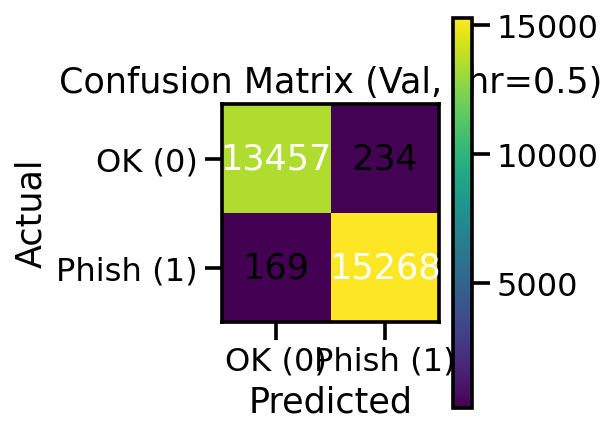

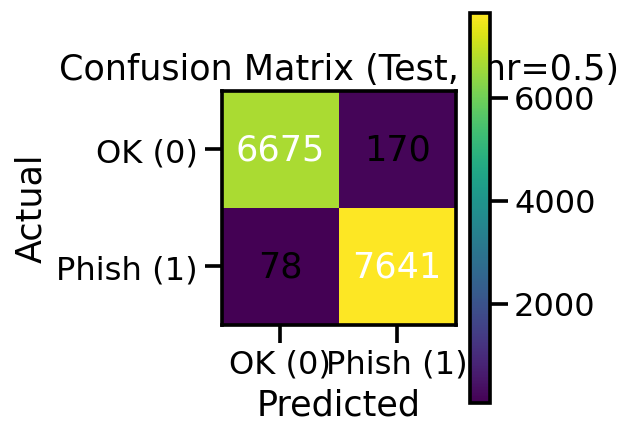

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_cm(y_true, y_score, threshold=0.5, title="Confusion Matrix"):
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title); ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['OK (0)','Phish (1)']); ax.set_yticklabels(['OK (0)','Phish (1)'])
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if im.norm(cm[i,j])>0.5 else "black")
    plt.colorbar(im); plt.tight_layout(); plt.show()
    return cm

_ = plot_cm(y_val,  val_proba,  threshold=0.5, title="Confusion Matrix (Val, thr=0.5)")
_ = plot_cm(y_test, test_proba, threshold=0.5, title="Confusion Matrix (Test, thr=0.5)")


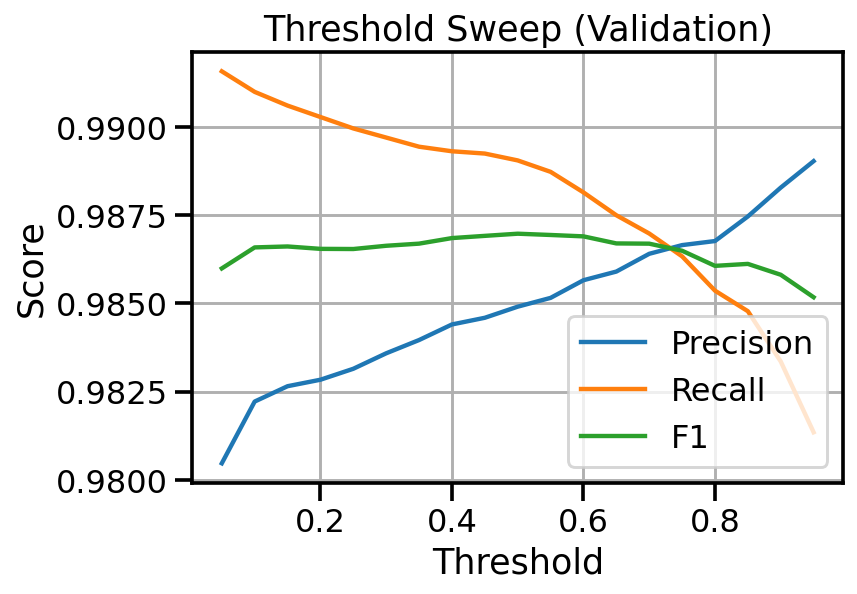

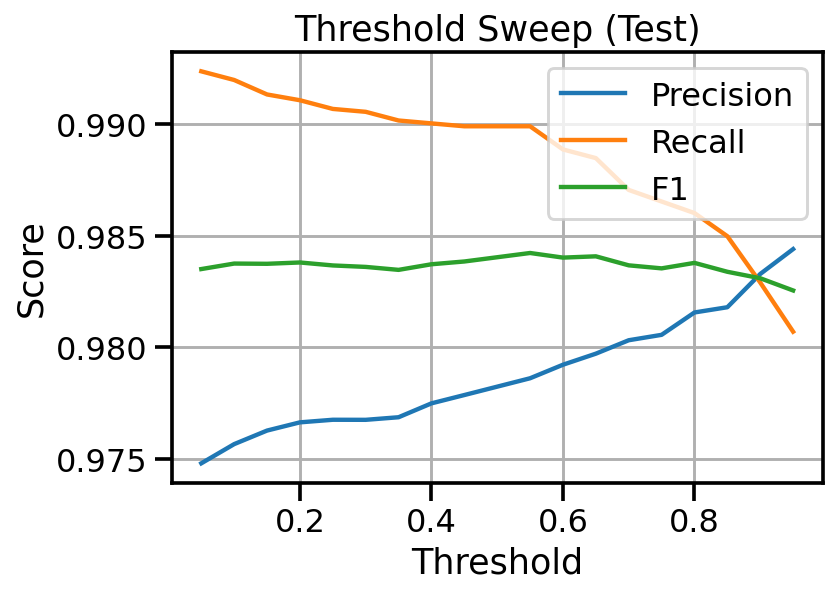

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_sweep(y_true, y_score):
    thr = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in thr:
        y_pred = (y_score >= t).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        rows.append((t,p,r,f1))
    return np.array(rows)

s_val  = threshold_sweep(y_val,  val_proba)
s_test = threshold_sweep(y_test, test_proba)

def plot_sweep(s, title):
    plt.figure(figsize=(6,4))
    plt.plot(s[:,0], s[:,1], label="Precision")
    plt.plot(s[:,0], s[:,2], label="Recall")
    plt.plot(s[:,0], s[:,3], label="F1")
    plt.xlabel("Threshold"); plt.ylabel("Score")
    plt.title(title); plt.legend(); plt.grid(True)
    plt.show()

plot_sweep(s_val,  "Threshold Sweep (Validation)")
plot_sweep(s_test, "Threshold Sweep (Test)")


In [ ]:
import pandas as pd
def top_errors(df_split, subj_vec, body_vec, y_true, y_score, k=10):
    # FN: true=1 but pred=0 (missed phishing)
    # FP: true=0 but pred=1 (false alarm)
    pred = (y_score >= 0.5).astype(int)
    err = pd.DataFrame({
        "subject": df_split['subject'].values,
        "body":    df_split['body'].values,
        "y_true":  y_true,
        "score":   y_score,
        "y_pred":  pred
    })
    fn = err[(err.y_true==1) & (err.y_pred==0)].sort_values("score", ascending=True).head(k)
    fp = err[(err.y_true==0) & (err.y_pred==1)].sort_values("score", ascending=False).head(k)
    return fn, fp

val_fn, val_fp = top_errors(val_df, val_subjects_vectorized, val_bodies_vectorized, y_val, val_proba, k=10)
test_fn, test_fp = top_errors(test_df, test_subjects_vectorized, test_bodies_vectorized, y_test, test_proba, k=10)

print("Top 10 False Negatives (Validation) — model least confident on phishing:")
display(val_fn[['subject','score']])
print("\nTop 10 False Positives (Validation) — highest-scored but actually OK:")
display(val_fp[['subject','score']])


Top 10 False Negatives (Validation) — model least confident on phishing:


,subject,score
13364,small business promotion,6.124919e-13
1198,This results in an infinite-extent image with ...,1.945152e-12
8130,King of the Sissies - Charles Burke - Articles...,2.216174e-11
12188,A short article on how and why it came to Wisc...,4.971358e-11
5442,check it,6.877841e-11
2318,yasheng group ( yhgg ) announces lst quarter r...,3.252391e-10
1382,become an a + certified pc technicia,3.687088e-10
10691,Mr. Sehen Sie G7Q am 4.Donnerstag!?,5.411286e-10
13001,UML tools generate diagrams and keep them in s...,6.393565e-10
9148,Washington State Employees Credit Union Alert,8.836315e-10



Top 10 False Positives (Validation) — highest-scored but actually OK:


,subject,score
8030,Salmon is good for your health. Please volunt...,1.0
14466,"Adam dont job for no one, see.",1.0
27502,"Adam dont job for no one, see.",1.0
19725,Re: no matter where you go,1.0
17731,7 properties in 57 hours…using none of my own ...,1.0
17957,seeing the barn red,1.0
17963,re : 3 . 376 help re : iaupe,1.0
22196,Question,1.0
26595,[Reform] (no subject),1.0
23204,[Reform] RE: Padilla jury in Miami to hear bin...,1.0


In [ ]:
import numpy as np
import pandas as pd

def length_buckets(text_series, bins=(0,50,150,300,600,10000)):
    # simple token approximation: split by whitespace on subject+body
    return pd.cut(text_series.str.split().apply(len), bins=bins)

# create combined text for quick length estimation
val_text  = (val_df['subject'].fillna('') + ' ' + val_df['body'].fillna(''))
test_text = (test_df['subject'].fillna('') + ' ' + test_df['body'].fillna(''))

def bucket_metrics(y_true, y_score, buckets):
    out = []
    for b in buckets.cat.categories:
        idx = buckets == b
        if idx.sum()==0: continue
        yt = y_true[idx]
        yp = (y_score[idx] >= 0.5).astype(int)
        from sklearn.metrics import accuracy_score, f1_score
        out.append((str(b), idx.sum(), accuracy_score(yt, yp), f1_score(yt, yp)))
    return pd.DataFrame(out, columns=["len_bucket","n","accuracy","f1"])

val_buckets  = length_buckets(val_text)
test_buckets = length_buckets(test_text)

val_len_table  = bucket_metrics(y_val,  val_proba,  val_buckets)
test_len_table = bucket_metrics(y_test, test_proba, test_buckets)

print("Validation — performance by length bucket")
display(val_len_table)
print("\nTest — performance by length bucket")
display(test_len_table)


Validation — performance by length bucket


,len_bucket,n,accuracy,f1
0,"(0, 50]",5179,0.978953,0.986809
1,"(50, 150]",9886,0.989885,0.990626
2,"(150, 300]",6546,0.988084,0.985609
3,"(300, 600]",5113,0.986309,0.986144
4,"(600, 10000]",2393,0.981195,0.970607



Test — performance by length bucket


,len_bucket,n,accuracy,f1
0,"(0, 50]",2584,0.971362,0.981925
1,"(50, 150]",4949,0.988887,0.990063
2,"(150, 300]",3286,0.982349,0.978503
3,"(300, 600]",2512,0.985669,0.985390
4,"(600, 10000]",1222,0.979542,0.966079


In [ ]:
from sklearn.metrics import classification_report

# Subject-only
val_prob_subj  = proba_preds(model, {'subject_input': val_subjects_vectorized,  'body_input': np.zeros_like(val_bodies_vectorized)})
test_prob_subj = proba_preds(model, {'subject_input': test_subjects_vectorized, 'body_input': np.zeros_like(test_bodies_vectorized)})

# Body-only
val_prob_body  = proba_preds(model, {'subject_input': np.zeros_like(val_subjects_vectorized),  'body_input': val_bodies_vectorized})
test_prob_body = proba_preds(model, {'subject_input': np.zeros_like(test_subjects_vectorized), 'body_input': test_bodies_vectorized})

def eval_bin(y_true, y_score, name):
    y_pred = (y_score>=0.5).astype(int)
    print(f"\n{name}")
    print(classification_report(y_true, y_pred, digits=4))

eval_bin(y_val,  val_prob_subj,  "Subject-only (Validation)")
eval_bin(y_test, test_prob_subj, "Subject-only (Test)")
eval_bin(y_val,  val_prob_body,  "Body-only (Validation)")
eval_bin(y_test, test_prob_body, "Body-only (Test)")



Subject-only (Validation)
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     13691
           1     0.5300    1.0000    0.6928     15437

    accuracy                         0.5300     29128
   macro avg     0.2650    0.5000    0.3464     29128
weighted avg     0.2809    0.5300    0.3672     29128


Subject-only (Test)
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      6845
           1     0.5300    1.0000    0.6928      7719

    accuracy                         0.5300     14564
   macro avg     0.2650    0.5000    0.3464     14564
weighted avg     0.2809    0.5300    0.3672     14564


Body-only (Validation)
              precision    recall  f1-score   support

           0     0.9876    0.9829    0.9852     13691
           1     0.9849    0.9891    0.9870     15437

    accuracy                         0.9862     29128
   macro avg     0.9863    0.9860    0.9861     29128
we

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
import pickle
model.save("lstm_gru_best.keras")
with open("subject_vectorizer.pkl","wb") as f: pickle.dump(vectorize_subject_layer, f)
with open("body_vectorizer.pkl","wb") as f: pickle.dump(vectorize_body_layer, f)

# Load later:
# model = tf.keras.models.load_model("lstm_gru_best.keras")
# vectorize_subject_layer = pickle.load(open("subject_vectorizer.pkl","rb"))
# vectorize_body_layer    = pickle.load(open("body_vectorizer.pkl","rb"))


In [ ]:
new_df = load_email_csv("/content/new_dataset.csv")

new_text = (new_df["subject"] + " " + new_df["body"]).astype(str)
X_new = text_vec(new_text)   # IMPORTANT: use SAME vectorizer used during training

proba = stacked_model.predict(X_new)
pred  = (proba >= 0.5).astype(int)

print(classification_report(new_df["label"].values, pred))
print("Accuracy:", accuracy_score(new_df["label"].values, pred))
